# Peak correlation with Cicero

In [1]:
library(cicero)
library(monocle3)
library(rhdf5)

Loading required package: monocle3

Warning message:
“package ‘monocle3’ was built under R version 4.2.1”


Loading required package: Biobase

Warning message:
“package ‘Biobase’ was built under R version 4.2.3”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Lo

In [2]:
# Print session info
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.9 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/libopenblasp-r0.3.25.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] rhdf5_2.42.0                cicero_1.3.9               
 [3] Gviz_1.42.0                 monocle3_1.0.0             
 [5] SingleCellExperiment_1.20.0 SummarizedExperiment_1.28.0
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.9        
 [

In [130]:
# Parse args
path_data <- "/cellar/users/aklie/data/datasets/neurips2021_small/annotation/2023_12_05/mdata.h5mu"
organism <- "human"
binarize <- FALSE
dim_reduction_key <- "X_lsi"
k <- 30
window <- 500000
path_all_peaks <- "/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/all_peaks.csv"
path_connections <- "/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/cicero_connections.csv"
path_cicero_out <- "/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/cicero_output.rds"
seed <- 1234

In [57]:
# Read genome
if (organism == 'human'){
    genome <- read.table('/cellar/users/aklie/opt/gene_program_evaluation/src/inference/grn_models/celloracle/resources/genome_sizes/human.txt')
} else {
    genome <- read.table('resources/genome_sizes/mouse.txt')
}

# Build CDS

In [98]:
# Process mudata
indata <- H5Fopen(path_data)
indices <- indata$mod$atac$layers$counts$indices
indptr <- indata$mod$atac$layers$counts$indptr
data <- as.numeric(indata$mod$atac$layers$counts$data)
barcodes <- indata$mod$atac$obs$`_index`
peaks <- indata$mod$atac$var$`_index`
h5closeAll()

In [99]:
print(length(barcodes))
print(length(peaks))

[1] 123
[1] 8192


In [100]:
# Build sparse matrix and binarize
indata <- Matrix::sparseMatrix(i=indices, p=indptr, x=data, index1 = FALSE)
if (binarize){
    indata@x[indata@x > 0] <- 1
}

In [101]:
indata[1:6, 1:6]

6 x 6 sparse Matrix of class "dgCMatrix"
                
[1,] . . . 2 . .
[2,] . . . . . .
[3,] . . 2 . . .
[4,] 2 . . . . .
[5,] . . . 2 . .
[6,] . . . . 2 .

In [102]:
# Format cell info
cellinfo <- data.frame(row.names=barcodes, cells=barcodes)
head(cellinfo)

,cells
,<chr>
AGCGCCTAGATGGACA-1-s1d1,AGCGCCTAGATGGACA-1-s1d1
CCTGAATAGCTTGCTC-1-s1d1,CCTGAATAGCTTGCTC-1-s1d1
AGAGATTAGTGTTGCG-1-s1d1,AGAGATTAGTGTTGCG-1-s1d1
GCTTGTTGTGCGCGTA-1-s1d1,GCTTGTTGTGCGCGTA-1-s1d1
TTTGTCCCATGGAGGC-1-s1d1,TTTGTCCCATGGAGGC-1-s1d1
GGTTGCGGTTGCTTCG-1-s1d1,GGTTGCGGTTGCTTCG-1-s1d1


In [103]:
# Format peak info
peaks <- gsub(":", "-", peaks)
peakinfo <- data.frame(row.names=peaks, site_name=peaks)
peakinfo <- tidyr::separate(data = peakinfo, col = 'site_name', into = c("chr", "bp1", "bp2"), sep = "-", remove=FALSE)
head(peakinfo)

,site_name,chr,bp1,bp2
,<chr>,<chr>,<chr>,<chr>
chr9-101486622-101487347,chr9-101486622-101487347,chr9,101486622,101487347
chr15-72237155-72238047,chr15-72237155-72238047,chr15,72237155,72238047
chr6-2124074-2124931,chr6-2124074-2124931,chr6,2124074,2124931
chr6-116668283-116669167,chr6-116668283-116669167,chr6,116668283,116669167
chr1-40315014-40315892,chr1-40315014-40315892,chr1,40315014,40315892
chr6-3126139-3127040,chr6-3126139-3127040,chr6,3126139,3127040


In [104]:
# Add names
row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

In [105]:
# Make CDS
input_cds <-  suppressWarnings(
    new_cell_data_set(
        indata,
        cell_metadata = cellinfo,
        gene_metadata = peakinfo
    )
)

# Preprocessing steps (optional)

In [106]:
set.seed(seed)

In [118]:
dim_reduction_key <- "X_umap"

In [119]:
# If dim_reduction_key "umap" or "lsi"
if (!is.null(dim_reduction_key)){
    print("Aggregating into metacells")
    if (dim_reduction_key == "umap" || dim_reduction_key == "lsi"){
        print(sprintf("Running %s dimensionality reduction with Cicero", dim_reduction_key))
        input_cds <- monocle3::detect_genes(input_cds)
        input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,]
        input_cds <- estimate_size_factors(input_cds)
        input_cds <- preprocess_cds(input_cds, method = "LSI")
        if (dim_reduction_key == "lsi"){
            coords <- reducedDims(input_cds)$LSI
        } else if (dim_reduction_key == "umap"){
            input_cds <- reduce_dimension(
                input_cds, 
                reduction_method = 'UMAP', 
                preprocess_method = "LSI"
            )
            coords <- reducedDims(input_cds)$UMAP
        }
    } else {
        print(sprintf("Getting precomputed %s coordinates from h5", dim_reduction_key))
        indata <- H5Fopen(path_data)
        coords <- t(indata$mod$atac$obsm[[dim_reduction_key]])
        rownames(coords) <- barcodes
        h5closeAll()
    }
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = coords, k=k)
} else {
    print("No dimensionality reduction specified, not using metacells")
    cicero_cds <- input_cds
}

[1] "Aggregating into metacells"
[1] "Getting precomputed X_umap coordinates from h5"


Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 24.9010752688172
Median shared cells bin-bin: 25

Warning message in make_cicero_cds(input_cds, reduced_coordinates = coords):
"On average, more than 10% of cells are shared between paired bins."


In [136]:
head(coords)

AGCGCCTAGATGGACA-1-s1d1,-2.22359896,3.570711
CCTGAATAGCTTGCTC-1-s1d1,-2.08471870,6.477296
AGAGATTAGTGTTGCG-1-s1d1,-0.83679533,6.805043
GCTTGTTGTGCGCGTA-1-s1d1,-0.04806462,4.696098
TTTGTCCCATGGAGGC-1-s1d1,0.63036299,8.695004
GGTTGCGGTTGCTTCG-1-s1d1,-0.69896770,6.535604


# Run cicero pipeline

In [121]:
distance_parameters <- estimate_distance_parameter(
    cicero_cds,
    window=window,
    maxit=100,
    sample_num=100,
    distance_constraint = round(window/2),
    distance_parameter_convergence=1e-22,
    genomic_coords=genome
)

Warning message in estimate_distance_parameter(cicero_cds, window = window, maxit = 100, :
"Could not calculate sample_num distance_parameters (71 were calculated) - see documentation details"


In [122]:
mean_distance_parameter <- mean(unlist(distance_parameters))
mean_distance_parameter

[1] 1.778067

In [123]:
print("Running models")
cicero_out <- generate_cicero_models(
    cicero_cds,
    distance_parameter=mean_distance_parameter,
    window=window,
    genomic_coords=genome
)

[1] "Running models"


In [125]:
print("Assembling connections")
conns <- assemble_connections(cicero_out, silent=FALSE)

[1] "Assembling connections"
[1] "Successful cicero models:  3582"
[1] "Other models: "

Zero or one element in range 
                        9518 
[1] "Models with errors:  0"


In [126]:
conns

,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr1-101079070-101079955,chr1-101236220-101237098,0.28632759
4,chr1-101236220-101237098,chr1-101079070-101079955,0.28632759
5,chr1-10387846-10388777,chr1-10494736-10495521,-0.05856646
6,chr1-10387846-10388777,chr1-10427794-10428684,0.13906257
8,chr1-10387846-10388777,chr1-10414970-10415871,0.59299930
9,chr1-10387846-10388777,chr1-10458872-10459783,-0.02961940
10,chr1-1040409-1041296,chr1-940004-940923,0.01096402
11,chr1-1040409-1041296,chr1-827067-827948,0.21964390
12,chr1-1040409-1041296,chr1-920754-921598,0.19335380


In [127]:
print("Saving")
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = file.path(path_all_peaks))
write.csv(x = conns, file = file.path(path_connections))
saveRDS(object = cicero_out, file = file.path(path_cicero_out))

[1] "Saving"


# Viz

In [138]:
# download and unzip
temp <- tempfile()
download.file("https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.gtf.gz", temp)
gene_anno <- rtracklayer::readGFF(temp)
unlink(temp)

In [139]:
# rename some columns to match requirements
gene_anno$chromosome <- paste0("chr", gene_anno$seqid)
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

In [141]:
peakinfo

,site_name,chr,bp1,bp2
,<chr>,<chr>,<chr>,<chr>
chr9-101486622-101487347,chr9-101486622-101487347,chr9,101486622,101487347
chr15-72237155-72238047,chr15-72237155-72238047,chr15,72237155,72238047
chr6-2124074-2124931,chr6-2124074-2124931,chr6,2124074,2124931
chr6-116668283-116669167,chr6-116668283-116669167,chr6,116668283,116669167
chr1-40315014-40315892,chr1-40315014-40315892,chr1,40315014,40315892
chr6-3126139-3127040,chr6-3126139-3127040,chr6,3126139,3127040
chr19-3721149-3722057,chr19-3721149-3722057,chr19,3721149,3722057
chr1-230149847-230150765,chr1-230149847-230150765,chr1,230149847,230150765
chr3-107598889-107599782,chr3-107598889-107599782,chr3,107598889,107599782


ERROR: Error in .local(GdObject, ...): Too many stacks to draw. Either increase the device size or limit the drawing to a smaller region.


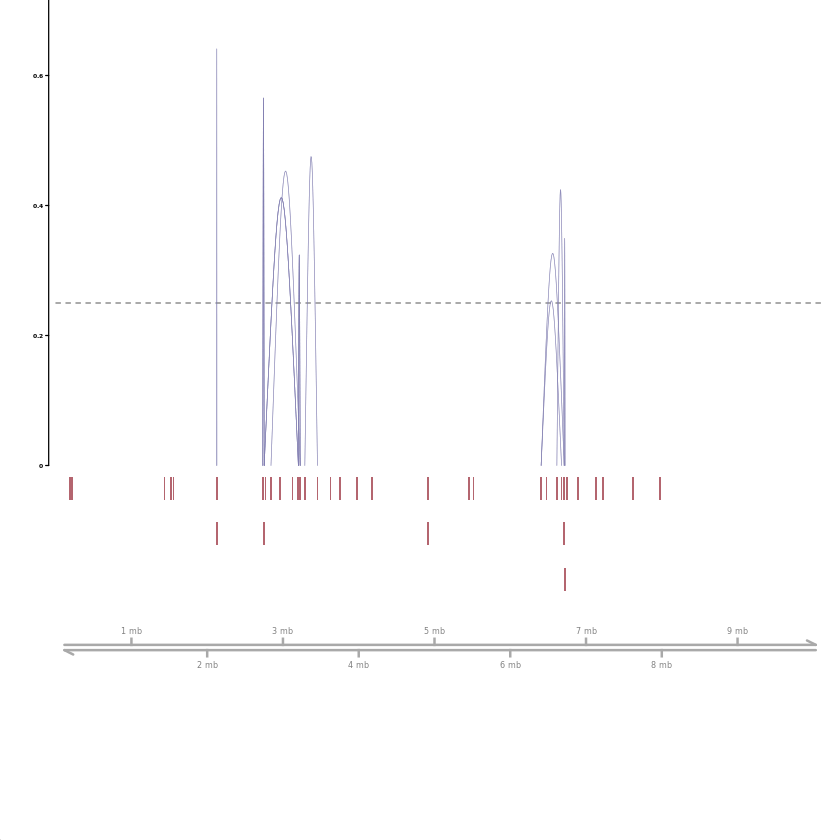

In [149]:
plot_connections(conns, "chr6", 1, 10148000,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .25, 
                 connection_width = .5, 
                 collapseTranscripts = "longest")

# Write command to run

```bash
Rscript /cellar/users/aklie/opt/gene_program_evaluation/src/inference/grn_models/celloracle/workflow/scripts/r2g.R \
/cellar/users/aklie/data/datasets/neurips2021_small/annotation/2023_12_05/mdata.h5mu \
human \
false \
X_umap \
30 \
500000 \
/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/all_peaks.csv \
/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/cicero_connections.csv \
/cellar/users/aklie/data/datasets/neurips2021_small/analysis/celloracle/2024_05_01/cicero_output.rds \
1234
```

# DONE

---